In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as pl
import seaborn as sb
from matplotlib.pylab import rcParams
from matplotlib import rc
import os
import glob

In [2]:
# GRAPHICS SETUP:
rc('font', **{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text',usetex=False)
fontSize=16
sb.set_style('dark')
rcParams['ytick.labelsize'] = fontSize
rcParams['xtick.labelsize'] = fontSize
%matplotlib notebook

In [3]:
-

In [4]:
mainDir='/accounts/ekarakoy/disk02/UNCERTAINTIES/Monte-Carlo/PACE_SNR/\
DATA/L2_L3/FullScale/GLOBALS/S2003193196/NIR_SensWithRhoT/'
simDirDict={k:'NIR_SNR_' + str(k) for k in range(500,850,50)}
l3bDir='L3bs'
filePattern = 'S20031932003196.L3b_4D*'

In [5]:
nirSnr = 750
fp = glob.glob(os.path.join(mainDir,simDirDict[nirSnr],l3bDir,filePattern))[0]

In [6]:
with nc.Dataset(fp) as ds:
    l3bVars = ds.groups['level-3_binned_data'].variables
    binlist = l3bVars['BinList'][:]
    wts = binlist['weights']
    bands = ['412', '443', '490', '510', '555', '670', '765', '865']
    rhoDict = {}
    rhoUncDict = {}
    rhotDict = {} 
    for band in bands:
        rhoDict[band] = np.pi * l3bVars['Rrs_%s' % band][:]['sum'] / wts
        rhoUncDict[band] = np.pi * l3bVars['Rrs_unc_%s' % band][:]['sum'] / wts
        rhotDict[band] = l3bVars['rhot_%s' % band][:]['sum'] / wts

In [7]:
rhoWUncDict = dict.fromkeys(bands)
xs = ['0','0.002','0.005','0.010']
for band in bands:
        rhoWUncDict[band] = dict.fromkeys(xs)
for band in bands:
    for xsi in xs:
        rhoWUncDict[band][xsi] = np.sqrt(
                                          np.power(rhoUncDict[band],2) + 
                                          np.power((float(xsi) * rhotDict[band]),2)
                                         )

<IPython.core.display.Javascript object>


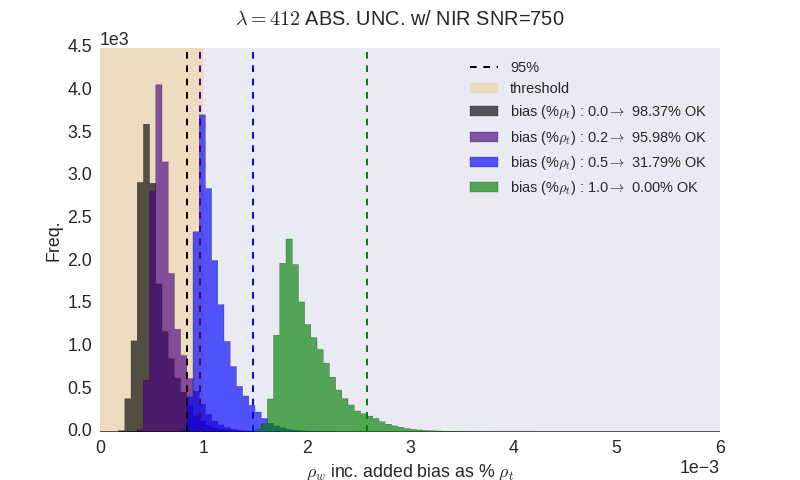

In [8]:
band='412'
snr = str(nirSnr)
mainFigDir = '/accounts/ekarakoy/UNCERTAINTIES/figs/ArtifactNoise/'
nirSnrDir = 'NIR_SNR_' + snr
figpath=os.path.join(mainFigDir,nirSnrDir,'lam_%s.png' % band)
rng = (0,6e-3)
PlotArtifacts(rhoWUncDict,artNoiseX=xs,savename=figpath,rng=rng,snr=nirSnr)

<IPython.core.display.Javascript object>


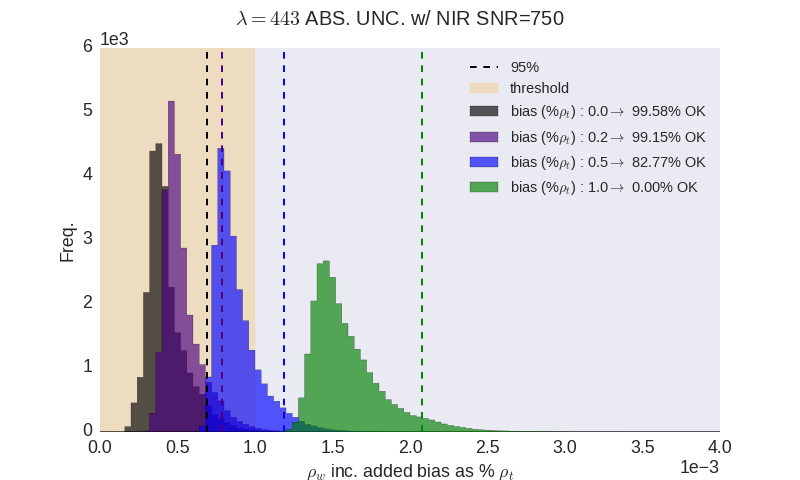

In [9]:
band='443'
mainFigDir = '/accounts/ekarakoy/UNCERTAINTIES/figs/ArtifactNoise/'
nirSnrDir = 'NIR_SNR_%d' % nirSnr 
figpath=os.path.join(mainFigDir,nirSnrDir,'lam_%s.png' % band)
rng = (0,4e-3)
PlotArtifacts(rhoWUncDict,artNoiseX=xs,savename=figpath,rnge=rng,band=band,
             snr=nirSnr)

<IPython.core.display.Javascript object>


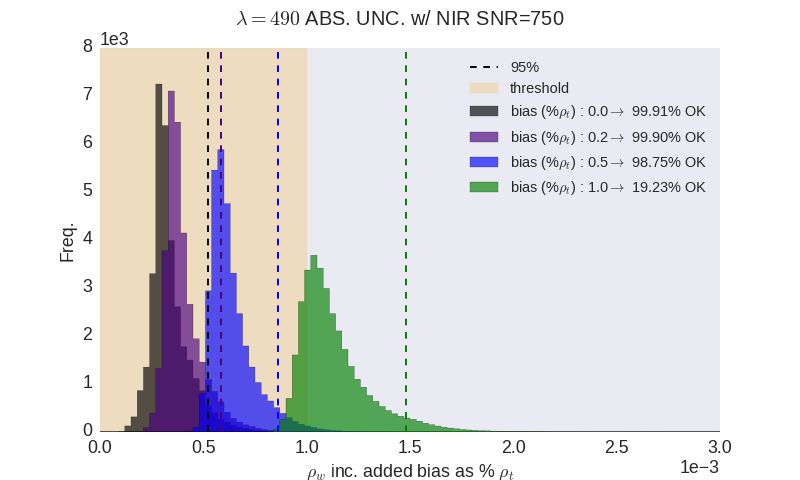

In [10]:
band='490'
mainFigDir = '/accounts/ekarakoy/UNCERTAINTIES/figs/ArtifactNoise/'
nirSnrDir = 'NIR_SNR_%d' % nirSnr 
figpath=os.path.join(mainFigDir,nirSnrDir,'lam_%s.png' % band)
rng = (0,3e-3)
PlotArtifacts(rhoWUncDict,artNoiseX=xs,savename=figpath,rnge=rng,band=band,
             snr=nirSnr)

<IPython.core.display.Javascript object>


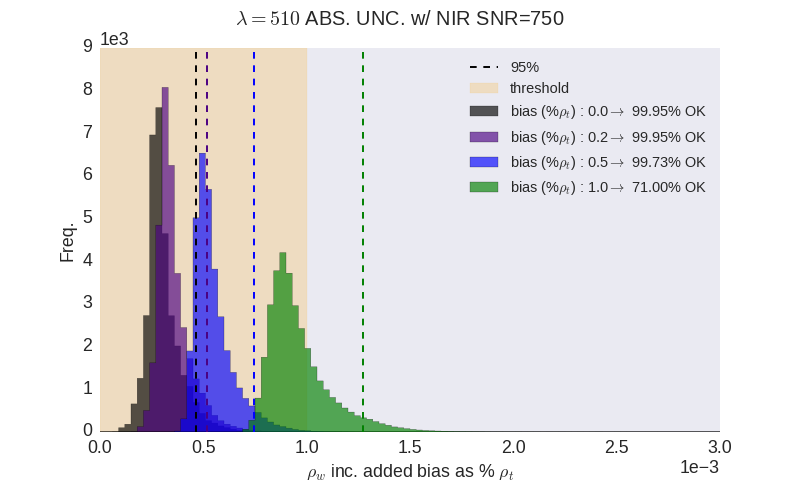

In [11]:
band='510'
mainFigDir = '/accounts/ekarakoy/UNCERTAINTIES/figs/ArtifactNoise/'
nirSnrDir = 'NIR_SNR_%d' % nirSnr 
figpath=os.path.join(mainFigDir,nirSnrDir,'lam_%s.png' % band)
rng = (0,3e-3)
PlotArtifacts(rhoWUncDict,artNoiseX=xs,savename=figpath,rnge=rng,band=band,
             snr=nirSnr)

In [12]:
rhoWUncDict = dict.fromkeys(bands)
xs = ['0','0.010','0.015','0.020']
for band in bands:
        rhoWUncDict[band] = dict.fromkeys(xs)
for band in bands:
    for xsi in xs:
        rhoWUncDict[band][xsi] = np.sqrt(
                                          np.power(rhoUncDict[band],2) + 
                                          np.power((float(xsi) * rhotDict[band]),2)
                                         )

<IPython.core.display.Javascript object>


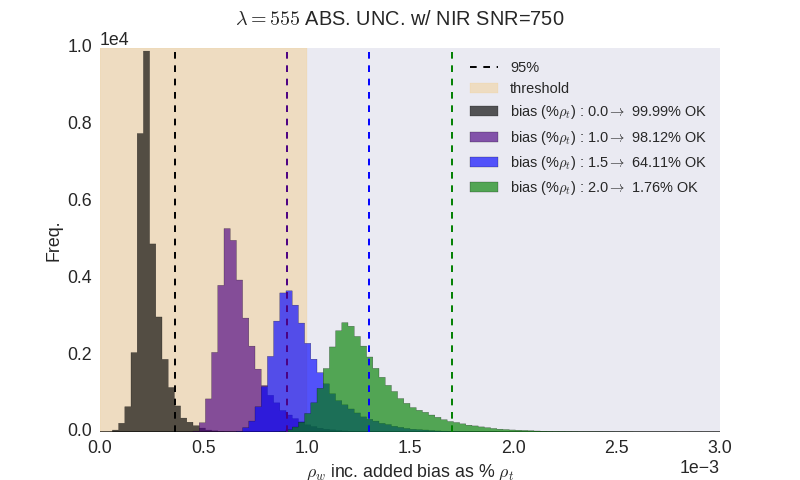

In [13]:
band='555'
mainFigDir = '/accounts/ekarakoy/UNCERTAINTIES/figs/ArtifactNoise/'
nirSnrDir = 'NIR_SNR_%d' % nirSnr 
figpath=os.path.join(mainFigDir,nirSnrDir,'lam_%s.png' % band)
rng = (0,3e-3)
PlotArtifacts(rhoWUncDict,artNoiseX=xs,savename=figpath,rnge=rng,band=band,
             snr=nirSnr)

In [14]:
# HERE WE FIND BIASES FOR EACH BAND SUCH THAT THE THRESHOLD IS MET

import pickle
import scipy.optimize

def FindBiasPercdata(x):
    global data
    global uncData
    thresh = 0.001
    targData = np.sqrt(np.power(uncData, 2) + np.power((x/100)*data, 2))
    sortedData = np.sort(targData)
    rho95 = sortedData[int(np.floor(sortedData.size * .95))]
    result = abs(rho95 - thresh)
    return result

Xfor95_path = '/accounts/ekarakoy/UNCERTAINTIES/datafiles/BiasError/XBiasFor95.p'
if os.path.exists(Xfor95_path):
    Xfor95Dict = pickle.load(open(Xfor95_path, 'rb'))
else:
    Xfor95Dict = dict.fromkeys(simDirDict.values())
Xfor95Dict[nirSnrDir] = dict.fromkeys(bands[:-2])
for band in bands[:-2]:
    data = rhotDict[band]
    uncData = rhoUncDict[band]
    rngs = slice(0, 5, 0.25)
    x_targ = scipy.optimize.brute(FindBiasPercdata, (rngs,))
    print("%s: %s: %.3f" % (nirSnrDir, band, x_targ))
    Xfor95Dict[nirSnrDir][band] = x_targ
pickle.dump(Xfor95Dict, open(Xfor95_path, 'wb'))
Xfor95Dict

NIR_SNR_750: 412: 0.224
NIR_SNR_750: 443: 0.375
NIR_SNR_750: 490: 0.621
NIR_SNR_750: 510: 0.752
NIR_SNR_750: 555: 1.123
NIR_SNR_750: 670: 2.127


{'NIR_SNR_500': {'412': array([ 0.]),
  '443': array([ 0.19462891]),
  '490': array([ 0.51796875]),
  '510': array([ 0.65932617]),
  '555': array([ 1.04951172]),
  '670': array([ 2.10302734])},
 'NIR_SNR_550': {'412': array([ 0.]),
  '443': array([ 0.26445312]),
  '490': array([ 0.55224609]),
  '510': array([ 0.68942871]),
  '555': array([ 1.07265625]),
  '670': array([ 2.11064453])},
 'NIR_SNR_600': {'412': array([ 0.082125]),
  '443': array([ 0.30742188]),
  '490': array([ 0.57685547]),
  '510': array([ 0.71154785]),
  '555': array([ 1.09003906]),
  '670': array([ 2.11630859])},
 'NIR_SNR_650': {'412': array([ 0.1569375]),
  '443': array([ 0.33710938]),
  '490': array([ 0.5953125]),
  '510': array([ 0.7284668]),
  '555': array([ 1.10351562]),
  '670': array([ 2.12080078])},
 'NIR_SNR_700': {'412': array([ 0.19658203]),
  '443': array([ 0.35859375]),
  '490': array([ 0.60966797]),
  '510': array([ 0.74135742]),
  '555': array([ 1.1140625]),
  '670': array([ 2.12412109])},
 'NIR_SNR_75

In [15]:
-

{'NIR_SNR_500': {'412': {'0': 0.0011184107,
   '0.002': 0.0012146807,
   '0.005': 0.0016363405,
   '0.010': 0.0026687302,
   '0.015': 0.0038253167,
   '0.020': 0.0050163269},
  '443': {'0': 0.00092991267,
   '0.002': 0.0010037575,
   '0.005': 0.001333173,
   '0.010': 0.0021503766,
   '0.015': 0.0030729473,
   '0.020': 0.0040243817},
  '490': {'0': 0.00071419269,
   '0.002': 0.00076234015,
   '0.005': 0.0009827402,
   '0.010': 0.001546131,
   '0.015': 0.0021906525,
   '0.020': 0.0028591638},
  '510': {'0': 0.00064402923,
   '0.002': 0.00068258232,
   '0.005': 0.00086379639,
   '0.010': 0.0013377706,
   '0.015': 0.0018847811,
   '0.020': 0.0024547318},
  '555': {'0': 0.00050265866,
   '0.002': 0.00052576221,
   '0.005': 0.00064425683,
   '0.010': 0.00096442411,
   '0.015': 0.0013405065,
   '0.020': 0.0017357029},
  '670': {'0': 0.00023457017,
   '0.002': 0.00025029131,
   '0.005': 0.0003230912,
   '0.010': 0.00051280571,
   '0.015': 0.00072908378,
   '0.020': 0.00095335476}},
 'NIR_SNR_5